In [1]:
#MH == Mental Health, PH == Physical Health
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('../input/mental-health-in-tech-2016/mental-heath-in-tech-2016_20161114.csv')

In [2]:
#Encode into question numbers for column reference
originals = data.columns
q_num = []

for i in range(0, len(originals)):
    q_num.append('Q' + str(i))
    
keys = q_num
values = originals
questions = dict(zip(keys, values))

data.columns = q_num

In [3]:
data['Q9'].unique()

array(['Very easy', 'Somewhat easy', 'Neither easy nor difficult', nan,
       'Very difficult', 'Somewhat difficult', "I don't know"],
      dtype=object)

In [4]:
null_columns = []

for col in data.columns:
    if data[col].isnull().any():
        perc = round((data[col].count() / data.count().max() * 100),2)
        if (col != 'Q23') & (col != 'Q48') & (col != 'Q49') & (col != 'Q50') & (col != 'Q51'):
            result = col + ": " + questions.get(col) + "(" + str(perc) + ")"
            null_columns.append(result)

In [5]:
#Replacing Q1 NaN (company size) with 'No answer'
data['Q1'].replace(np.nan, 'No answer', inplace = True)

#Replacing Q2 (is a tech company) with 0.0 for no
data['Q2'].replace(np.nan, 0.0, inplace=True)

#Replacing Q4 NaN (Mental health coverage) with already present N/A value
data['Q4'].replace(np.nan, 'Not eligible for coverage / N/A', inplace=True)

#Adding no answer field in place of NaN to Q5 - Q16, excluding Q9 (yes / no / don't know / maybe option variations)
for i in range(5,23):
    if (i != 9):
        data['Q' + str(i)].replace(np.nan, 'No answer', inplace = True)
    
#Grouping Q9 NaN (Ease of mental health leave) into don't know
data['Q9'].replace(np.nan, "I don't know", inplace = True)

#Q23 NaN stay: If yes answer, NaN excluded in graphs, so accurate representation

#Grouping Q25 NaN (Previous mental health benefits) into I don't know
data['Q25'].replace(np.nan, "I don't know", inplace = True)

#Grouping Q26 NaN (Aware of MH options from previous employers) into existing NA category
data['Q26'].replace(np.nan, 'N/A (not currently aware)', inplace = True)

#Grouping Q27 NaN (Previous employer discuss mental health) into Don't know
data['Q27'].replace(np.nan, "I don't know", inplace = True)

#Replacing Q43, Q44 (observed negative response & impact) with No answer
data['Q43'].replace(np.nan, 'No answer', inplace = True)
data['Q44'].replace(np.nan, 'No answer', inplace = True)

#Replacing Q56 (gender, few NaN values) with 'none of your business' (placeholder)
data['Q56'].replace(np.nan, 'none of your business', inplace = True)

#Adding "no answer" to location (Q58&60)
data['Q58'].replace(np.nan, 'No answer', inplace = True)
data['Q60'].replace(np.nan, 'No answer', inplace = True)

In [6]:
for i in range(28,36):
    l = data['Q' + str(i)].unique()
    if "I don't know" in l:
        data['Q' + str(i)].replace(np.nan, "I don't know", inplace = True)
    else:
        data['Q' + str(i)].replace(np.nan, 'No answer', inplace = True)

In [7]:
#Filling role related to tech (Q3): 0 if in non-tech list of job roles (Q61), 1 if not
def tech_related(role, role_name):
    if np.isnan(role):
        if(role_name in non_tech):
            return 0
        else:
            return 1
    else:
        return role
    
non_tech = ['HR', 'Other|HR', 'HR|Supervisor/Team Lead|Executive Leadership', 'Executive Leadership',
           'HR|Dev Evangelist/Advocate|Sales']

data['Q3'] = data.apply(lambda x: x.fillna(tech_related(x.Q3, x.Q61)), axis = 1)

In [8]:
#Cleaning up free text field for Q56 Gender & categorising
def gender_cat(x):
    if ('trans' in x) | ('transgender' in x):
        return 'transgender'
    elif any(g in x for g in ['fluid', 'genderqueer', 'binary']):
        return 'genderfluid / non-binary'
    elif (x == 'f') or any(f in x for f in ['female', 'woman']):
        return 'female'
    elif (x == 'm') or any(m in x for m in ['male', 'man', 'malr', 'm|', 'dude']):
        return 'male'
    else:
        return 'Other / No answer'
    

data['Q56'] = data['Q56'].str.lower()
data['Q56'] = data['Q56'].apply(lambda x: gender_cat(x))

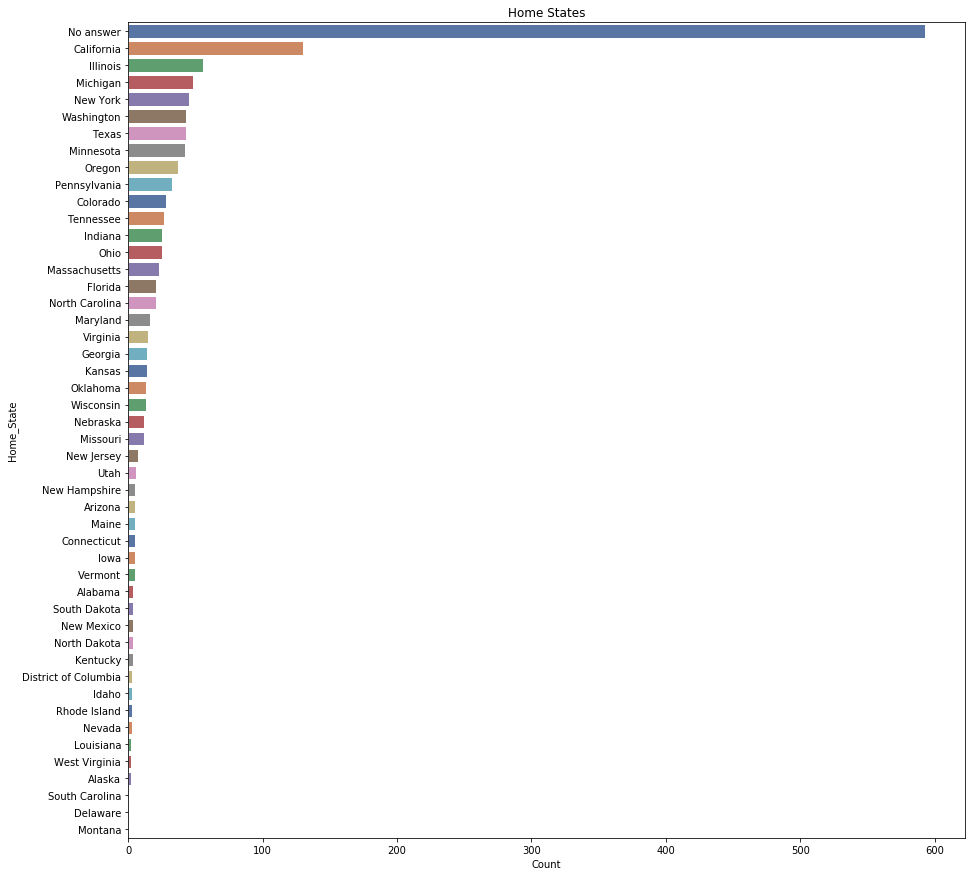

In [9]:
live_loc = data.groupby('Q58', as_index = False).agg({'Q0':'count'}).rename(columns={'Q0':'Count', 'Q58':'Home_State'})
live_loc = live_loc.sort_values(by=['Count'], ascending = False)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Home States')
sns.set(style='whitegrid')
ax = sns.barplot('Count', 'Home_State', ax=ax, palette="deep", data=live_loc)
plt.show()

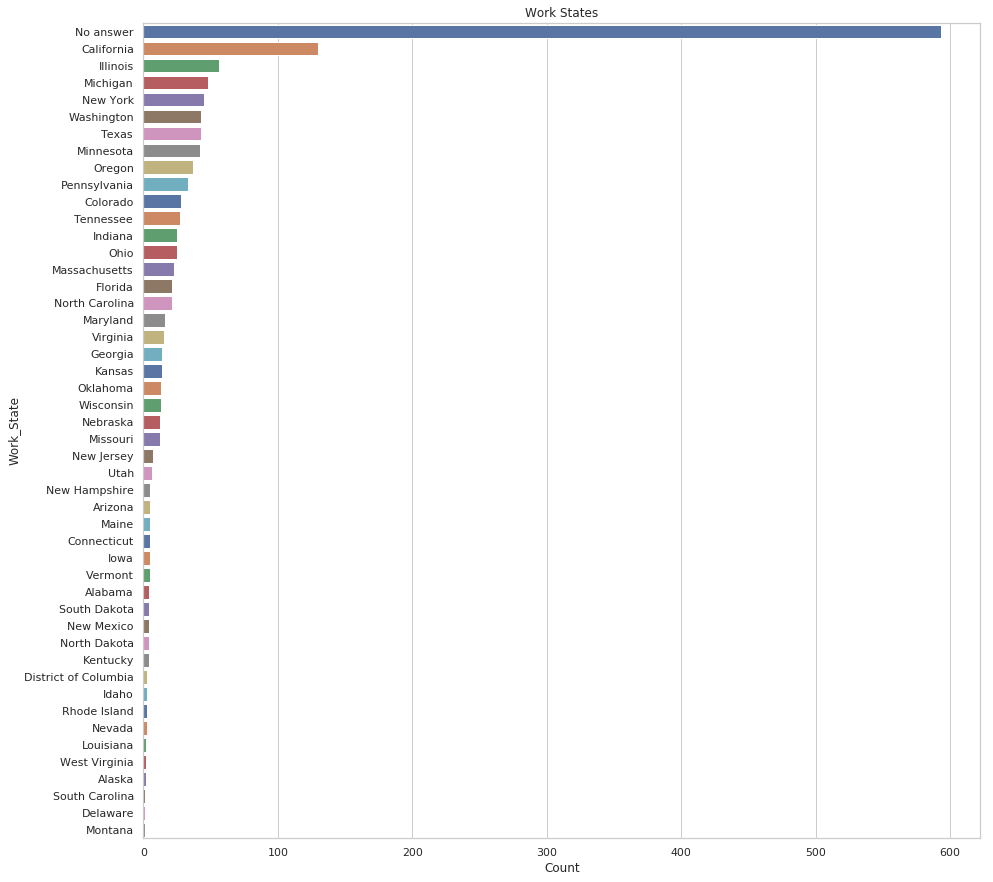

In [10]:
work_loc = data.groupby('Q58', as_index = False).agg({'Q0':'count'}).rename(columns={'Q0':'Count', 'Q58':'Work_State'})
work_loc = work_loc.sort_values(by=['Count'], ascending = False)

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title('Work States')
sns.set(style='whitegrid')
ax = sns.barplot('Count', 'Work_State', ax=ax, palette="deep", data=work_loc)
plt.show()

<h3>States / Locations</h3>

<ul>
    <li>Majority provided no answer</li>
    <li>Distribution very unequal (e.g. California vs. Montana)</li>
    <li>Representation of major tech hot-spots</li>
    <li>Correlation to mental health answers difficult due to group sizes</li>
</ul>

<p><em>Dropping state columns and focusing on entire US</em></p>

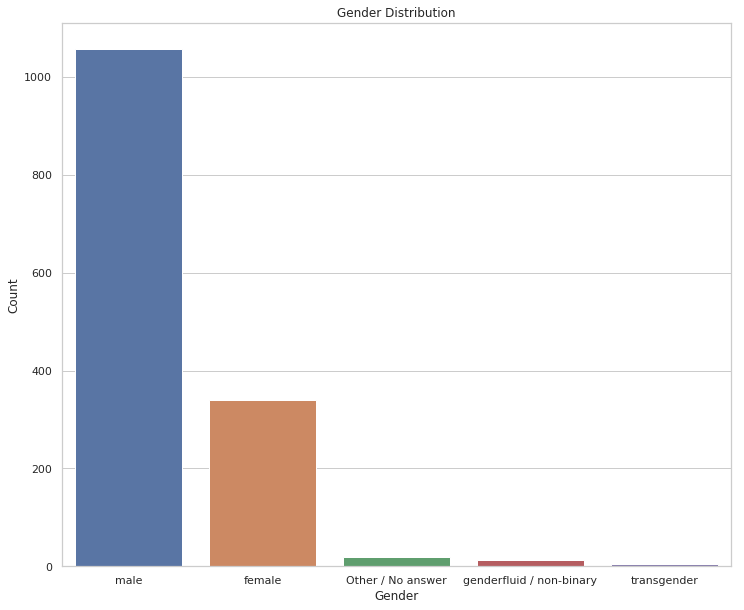

In [11]:
gender = data.groupby('Q56', as_index = False).agg({'Q0':'count'}).rename(columns={'Q0':'Count', 'Q56':'Gender'})
gender = gender.sort_values(by=['Count'], ascending = False)

fig, ax = plt.subplots(1,1,figsize=(12,10))
ax.set_title('Gender Distribution')
sns.set(style='whitegrid')
ax = sns.barplot('Gender', 'Count', ax=ax, palette="deep", data=gender)
plt.show()

<h3>Gender Distribution</h3>

<ul>
    <li>More men than women (probably due to limit to tech roles)</li>
    <li>About 20-25% female, 75-80% male, max. 5% other</li>
    <li>Correlation between gender & mental health / mental health disclosure?</li>
</ul>

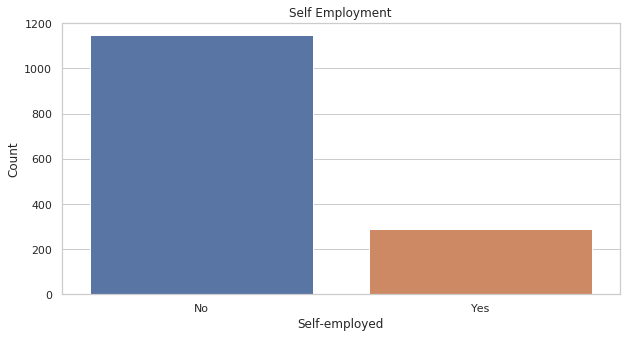

In [12]:
self_employed = data.groupby('Q0', as_index = False).agg({'Q1':'count'}).rename(columns={'Q0':'Self-employed','Q1':'Count'})
self_employed['Self-employed'] = self_employed['Self-employed'].replace([0,1], ['No','Yes'])

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Self Employment')
sns.set(style='whitegrid')
ax = sns.barplot('Self-employed', 'Count', ax=ax, palette="deep", data=self_employed)
plt.show()

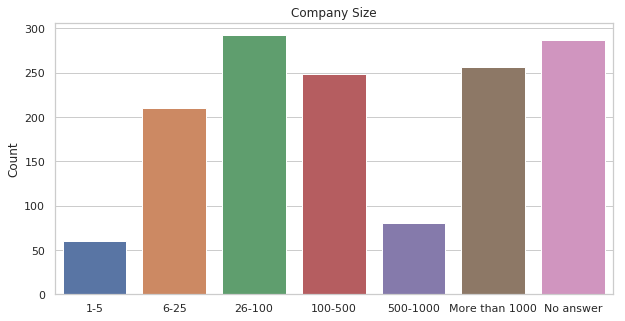

In [13]:
company = data.groupby('Q1', as_index = False).agg({'Q0':'count'}).rename(columns={'Q1':'Company_Size','Q0':'Count'})
plt_order = ['1-5','6-25','26-100','100-500','500-1000','More than 1000', 'No answer']

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Company Size')
sns.set(style='whitegrid')
ax = sns.barplot('Company_Size', 'Count', ax=ax, palette="deep", data=company, order=plt_order)
ax.set(xlabel='')
plt.show()

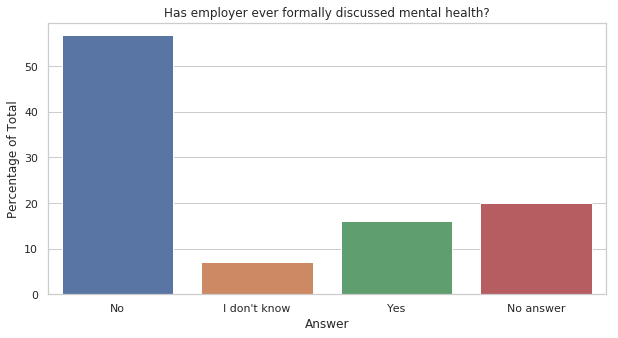

In [14]:
mh_discussion = data.groupby('Q6', as_index = False).agg({'Q0':'count'}).rename(columns={'Q6':'MH_Discussed','Q0':'Count'})
plt_order = ['No', "I don't know", 'Yes', 'No answer']
total = mh_discussion['Count'].sum()

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Has employer ever formally discussed mental health?')
sns.set(style='whitegrid')
ax = sns.barplot('MH_Discussed', 'Count', ax=ax, palette="deep", data=mh_discussion, order=plt_order, 
                 estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()

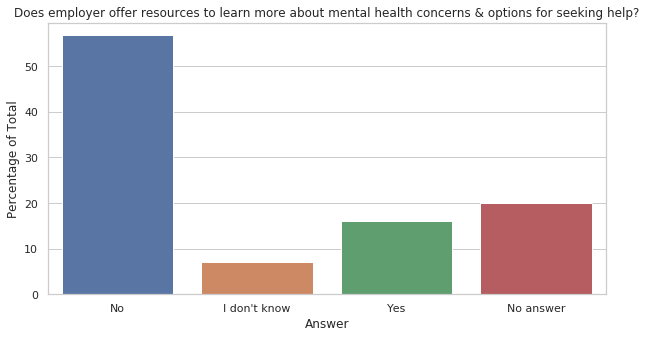

In [15]:
mh_help = data.groupby('Q6', as_index = False).agg({'Q0':'count'}).rename(columns={'Q6':'Help','Q0':'Count'})
total = mh_help['Count'].sum()

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Does employer offer resources to learn more about mental health concerns & options for seeking help?')
sns.set(style='whitegrid')
ax = sns.barplot('Help', 'Count', ax=ax, palette="deep", data=mh_help, order=plt_order, estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()

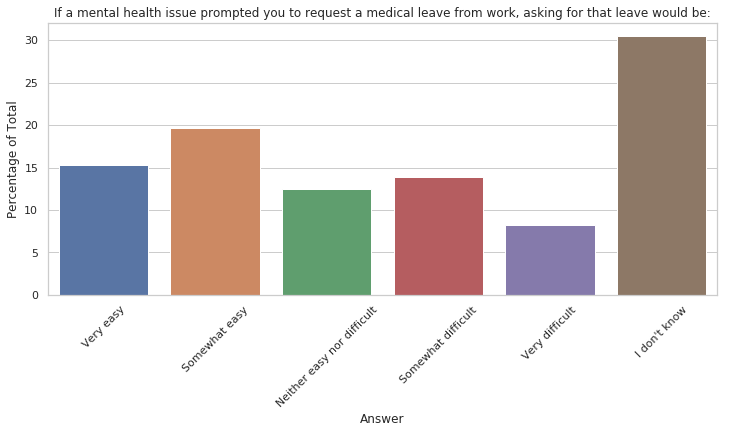

In [16]:
mh_leave = data.groupby('Q9', as_index = False).agg({'Q0':'count'}).rename(columns={'Q9':'Leave','Q0':'Count'})
plt_order = ['Very easy', 'Somewhat easy', 'Neither easy nor difficult', 'Somewhat difficult', 'Very difficult', "I don't know"]
total = mh_leave['Count'].sum()

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:')
sns.set(style='whitegrid')
ax.set_xticklabels(labels=mh_leave['Leave'], rotation=45)
ax = sns.barplot('Leave', 'Count', ax=ax, palette="deep", data=mh_leave, order = plt_order,
                 estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()

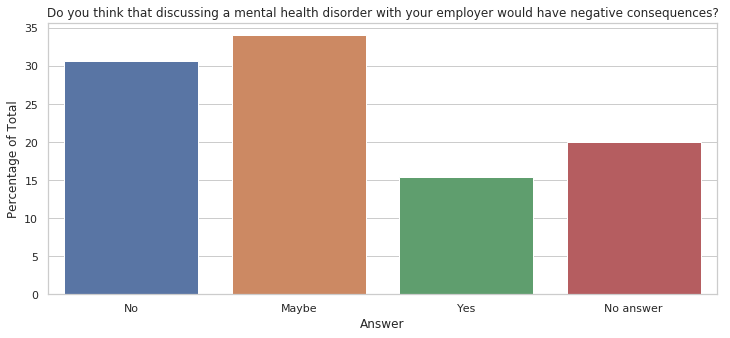

In [17]:
mh_cons = data.groupby('Q10', as_index = False).agg({'Q0':'count'}).rename(columns={'Q10':'Consequences','Q0':'Count'})
plt_order = ['No','Maybe','Yes','No answer']
total = mh_cons['Count'].sum()

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Do you think that discussing a mental health disorder with your employer would have negative consequences?')
sns.set(style='whitegrid')
ax = sns.barplot('Consequences', 'Count', ax=ax, palette="deep", data=mh_cons, order=plt_order,
                 estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()

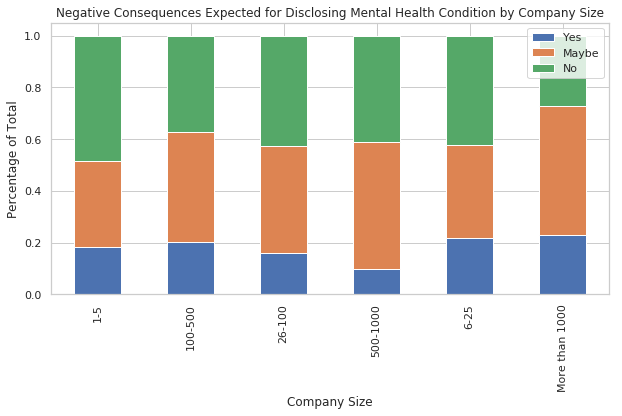

In [18]:
answered = data[data['Q1']!='No answer'].copy()
answered_enc = answered.copy()
answered_enc['Q10'] = answered['Q10'].replace(['Yes','Maybe','No'], [1,2,3])

size_consequences = pd.crosstab(answered_enc['Q1'], answered_enc['Q10']).apply(lambda r: r/r.sum(), axis=1)

ax = size_consequences.plot.bar(stacked = True, figsize=(10,5))
ax.set_title('Negative Consequences Expected for Disclosing Mental Health Condition by Company Size')
ax.set(xlabel='Company Size', ylabel='Percentage of Total')
ax.legend(labels=['Yes','Maybe','No'])
plt.show()

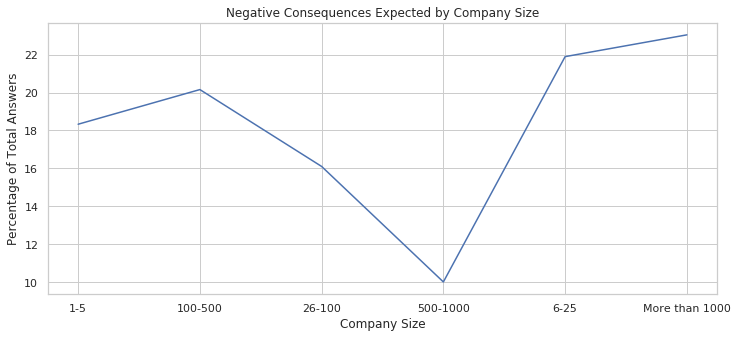

In [19]:
def percentage(x, y):
    return round((x / y * 100),2)

consequences_expected = answered[answered['Q10'] == 'Yes']

cons_yes_size = consequences_expected.groupby('Q1', as_index=False).agg({'Q10':'count'})
totals = data.groupby('Q1', as_index=False).agg({'Q0':'count'})

cons_yes_size['totals'] = totals['Q0']
cons_yes_size['Q10'] = cons_yes_size.apply(lambda x: percentage(x.Q10, x.totals), axis=1)
cons_yes_size = cons_yes_size.drop(['totals'], axis = 1)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Negative Consequences Expected by Company Size')
sns.set(style='whitegrid')
ax = sns.lineplot('Q1', 'Q10', ax=ax, data=cons_yes_size)
ax.set(xlabel='Company Size', ylabel='Percentage of Total Answers')
plt.show()

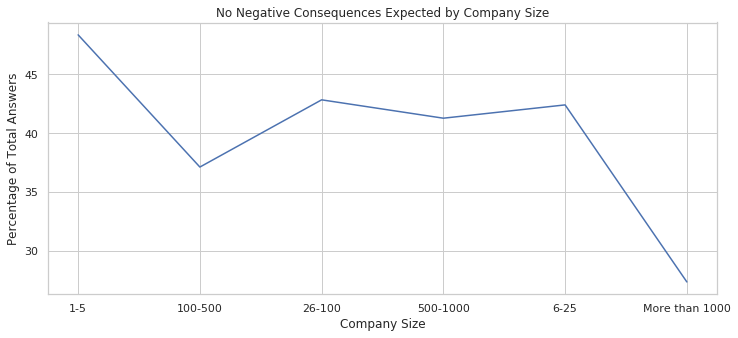

In [20]:
consequences_expected = answered[answered['Q10'] == 'No']

cons_yes_size = consequences_expected.groupby('Q1', as_index=False).agg({'Q10':'count'})
totals = data.groupby('Q1', as_index=False).agg({'Q0':'count'})

cons_yes_size['totals'] = totals['Q0']
cons_yes_size['Q10'] = cons_yes_size.apply(lambda x: percentage(x.Q10, x.totals), axis=1)
cons_yes_size = cons_yes_size.drop(['totals'], axis = 1)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('No Negative Consequences Expected by Company Size')
sns.set(style='whitegrid')
ax = sns.lineplot('Q1', 'Q10', ax=ax, data=cons_yes_size)
ax.set(xlabel='Company Size', ylabel='Percentage of Total Answers')
plt.show()

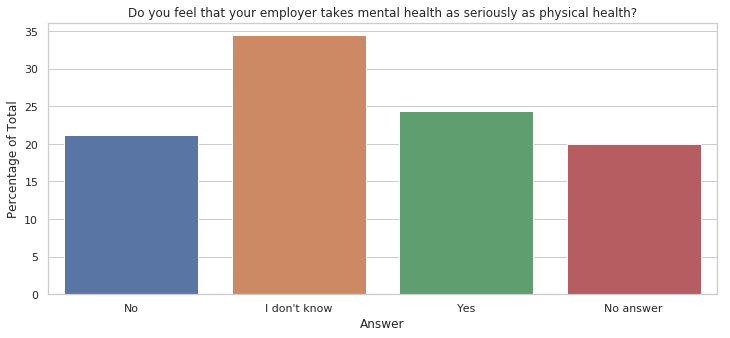

In [21]:
mh_serious = data.groupby('Q14', as_index = False).agg({'Q0':'count'}).rename(columns={'Q14':'Understanding','Q0':'Count'})
plt_order = ['No',"I don't know",'Yes','No answer']
total = mh_serious['Count'].sum()

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Do you feel that your employer takes mental health as seriously as physical health?')
sns.set(style='whitegrid')
ax = sns.barplot('Understanding', 'Count', ax=ax, palette="deep", data=mh_serious, order = plt_order,
                 estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()


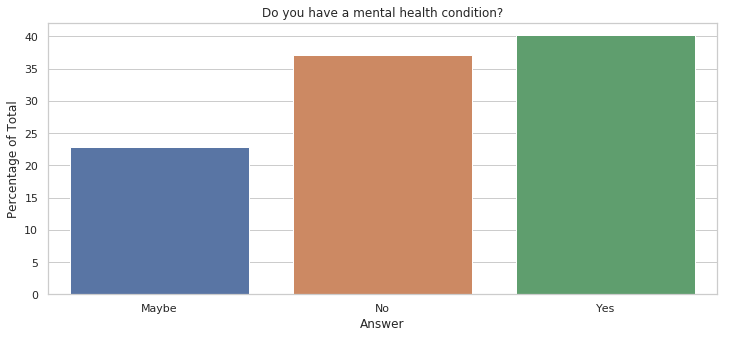

In [22]:
mh = data.groupby('Q47', as_index = False).agg({'Q0':'count'}).rename(columns={'Q47':'MH', 'Q0':'Count'})
total = data['Q47'].count()

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Do you have a mental health condition?')
sns.set(style='whitegrid')
ax = sns.barplot('MH', 'Count', ax=ax, palette="deep", data=mh,
                 estimator=lambda x: sum(x)/total*100.0)
ax.set(xlabel='Answer', ylabel='Percentage of Total')
plt.show()

In [23]:
def diagnose(x):
    x = str(x).lower()
    if(x == 'nan'):
        return 'No answer'
    if 'anxiety disorder' in x:
        return 'Anxiety Disorder'
    elif ('mood disorder' in x) or ('depression' in x) or ('burn out' in x):
        return 'Mood Disorder'
    elif ('autism' in x) or ('pdd-nos' in x):
        return 'ASD'
    elif 'attention deficit hyperactivity disorder' in x:
        return 'ADHD'
    elif 'obsessive-compulsive disorder' in x:
        return 'OCD'
    elif 'personality' in x:
        return 'Personality Disorder'
    elif ('post-traumatic stress disorder' in x):
        return 'PTSD'
    elif ('addiction' in x) or ('substance' in x) or ('addictive' in x):
        return 'Addiction'
    elif 'psychotic' in x:
        return 'Psychosis'
    else:
        return 'Other'
    
    

data['Q48'] = data['Q48'].apply(lambda x: diagnose(x))

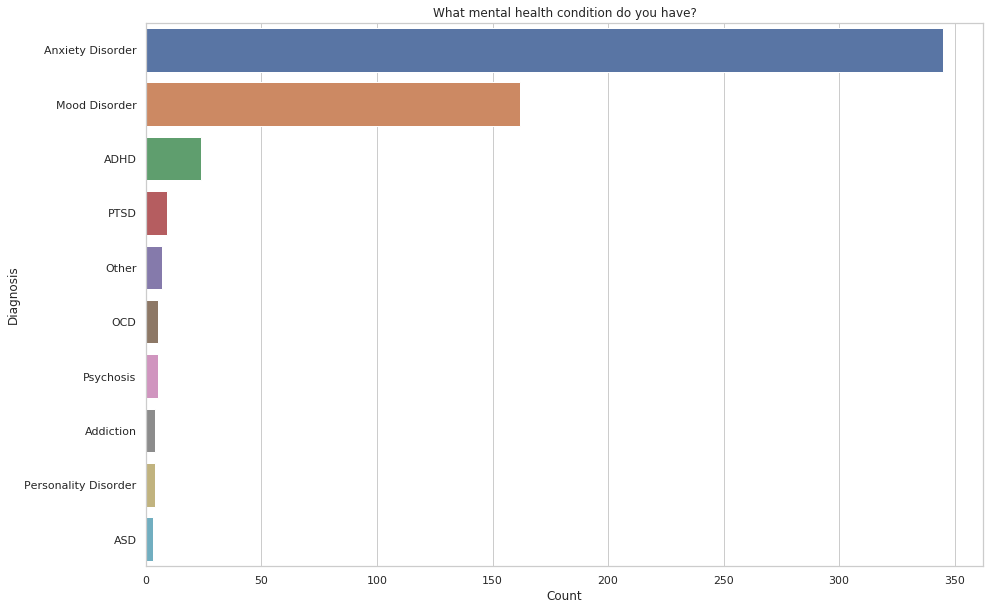

In [24]:
mh_cond = data.groupby('Q48', as_index = False).agg({'Q0':'count'}).rename(columns={'Q48':'Diagnosis', 'Q0':'Count'})
mh_cond = mh_cond.sort_values(by=['Count'], ascending = False)
total = data['Q48'].count()

mh_cond = mh_cond[mh_cond['Diagnosis']!='No answer']

fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('What mental health condition do you have?')
sns.set(style='whitegrid')
ax = sns.barplot('Count', 'Diagnosis', ax=ax, palette="deep", data=mh_cond)
ax.set(xlabel='Count', ylabel='Diagnosis')
plt.show()